<a href="https://colab.research.google.com/github/sorennelson/Deep_Learning_with_Python/blob/master/Variational_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
from keras.datasets import mnist

import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

Using TensorFlow backend.


In [0]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

shape_before_flattening = K.int_shape(x)

In [0]:
# Encoding
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [5]:
def sampling(args):
  z_mean, z_log_var = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
  return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

W0813 01:26:39.311379 140252987811712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



In [0]:
# Decoding
decoder_input = layers.Input(K.int_shape(z)[1:])

x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2,2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)
z_decoded = decoder(z)

In [0]:
class CustomVariationalLayer(keras.layers.Layer):
  '''Used to compute loss--not a normal loss function with an input and a target passed in'''

  def vae_loss(self, x, z_decoded):
      x = K.flatten(x)
      z_decoded = K.flatten(z_decoded)
      xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
      kl_loss = -5e-4 * K.mean(
          1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
      return K.mean(xent_loss + kl_loss)

  def call(self, inputs):
      x = inputs[0]
      z_decoded = inputs[1]
      loss = self.vae_loss(x, z_decoded)
      self.add_loss(loss, inputs=inputs)
      return x  # not used
  
y = CustomVariationalLayer()([input_img, z_decoded])

In [9]:
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None) # use above loss
vae.summary()

W0813 01:27:08.118329 140252987811712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (

In [10]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))

x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None, shuffle=True, epochs=10, batch_size=batch_size, validation_data=(x_test, None))

11493376/11490434 [==============================] - 2s 0us/step
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 30s 501us/step - loss: 786334412.7490 - val_loss: 0.2021
Epoch 2/10
60000/60000 [==============================] - 23s 382us/step - loss: 0.1971 - val_loss: 0.1937
Epoch 3/10
60000/60000 [==============================] - 23s 376us/step - loss: 0.1906 - val_loss: 0.1898
Epoch 4/10
60000/60000 [==============================] - 23s 378us/step - loss: 0.1872 - val_loss: 0.1865
Epoch 5/10
60000/60000 [==============================] - 23s 381us/step - loss: 0.1852 - val_loss: 0.1855
Epoch 6/10
60000/60000 [==============================] - 23s 377us/step - loss: 0.1839 - val_loss: 0.1861
Epoch 7/10
60000/60000 [==============================] - 22s 374us/step - loss: 0.1831 - val_loss: 0.1839
Epoch 8/10
60000/60000 [==============================] - 22s 369us/step - loss: 0.1822 - val_loss: 0.1830
Epoch 9/10
60000/6000

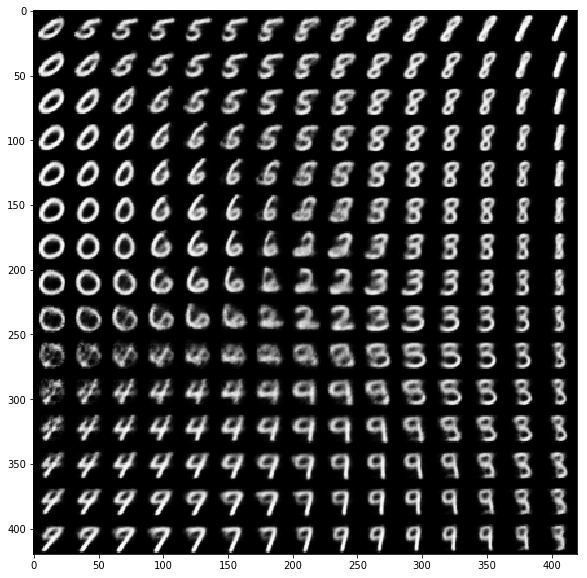

In [13]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
  for j, xi in enumerate(grid_y):
    z_sample = np.array([[xi, yi]])
    z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
    
    x_decoded = decoder.predict(z_sample, batch_size=batch_size)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[i * digit_size: (i+1) * digit_size, j * digit_size: (j+1) * digit_size] = digit
    
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()